In [42]:
import pandas as pd
import json
import sweetviz
import numpy as np
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay
import seaborn as sns

In [19]:
data = pd.read_csv('../data/trial1.csv')

In [20]:
data = pd.concat(
        [
            data.drop(columns=['Unnamed: 0', 'observation_id', 'id', 'observation']),
            data.observation.apply(lambda x: json.loads(x)).apply(pd.Series)
        ],
        axis=1
    )

In [21]:
data.columns

Index(['prediction', 'proba', 'true_class', 'observation_id', 'Type', 'Date',
       'Part of a policing operation', 'Latitude', 'Longitude', 'Gender',
       'Age range', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station'],
      dtype='object')

                                             |          | [  0%]   00:00 -> (? left)


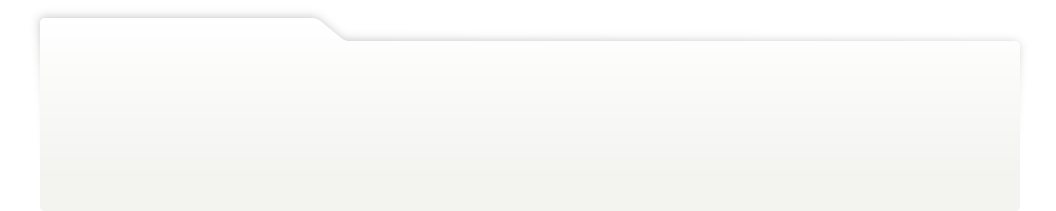
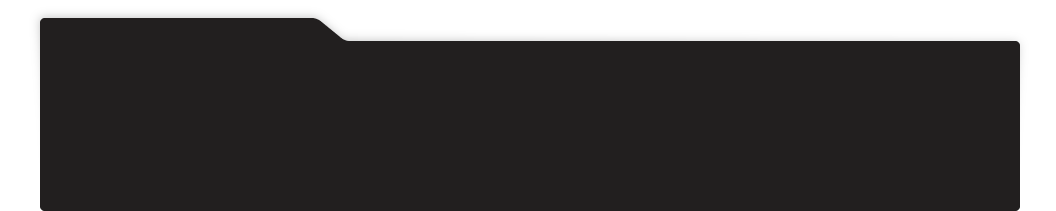
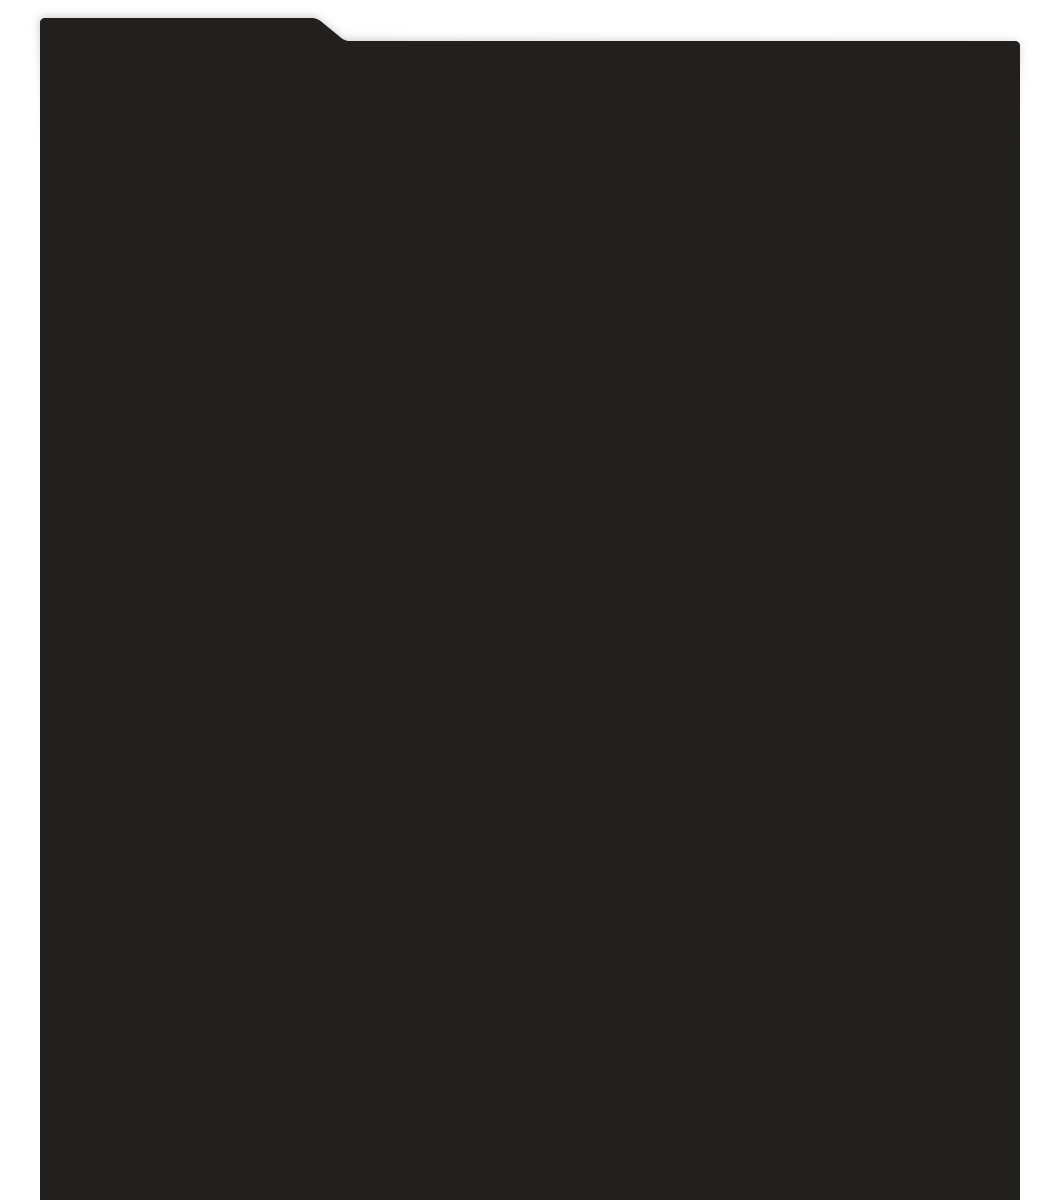
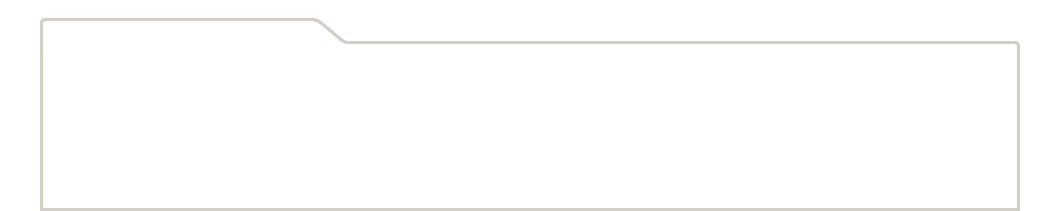
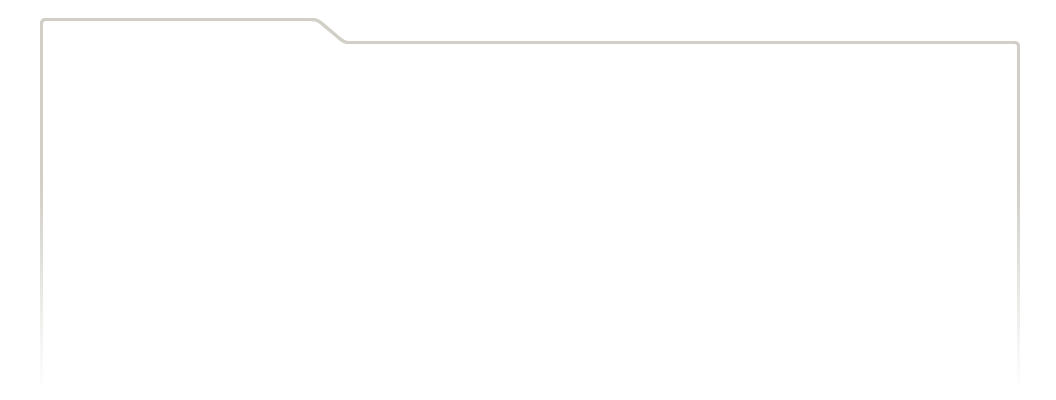
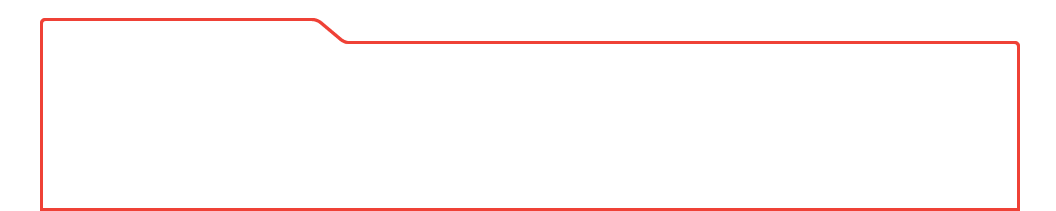
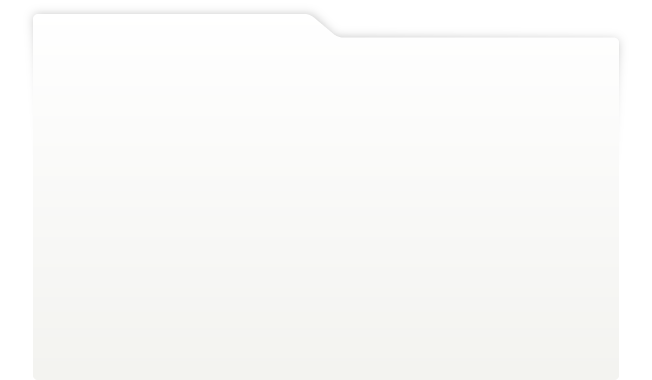
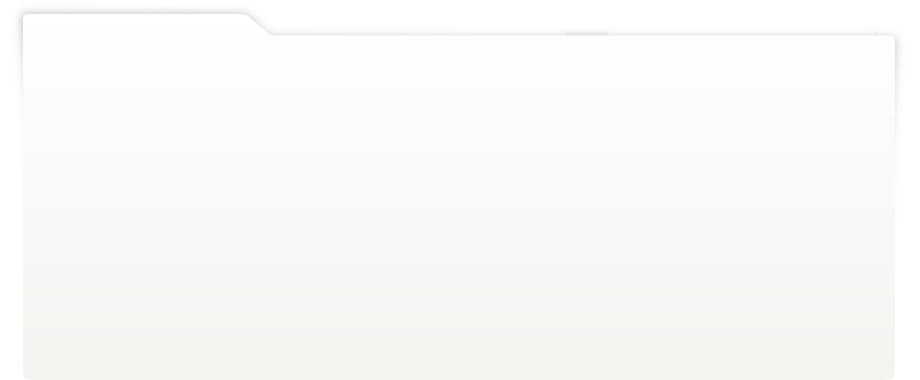
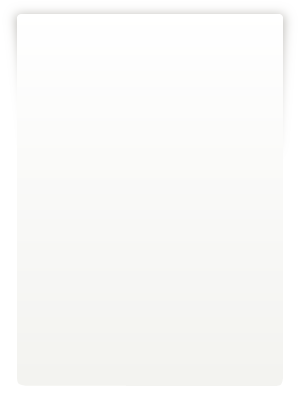
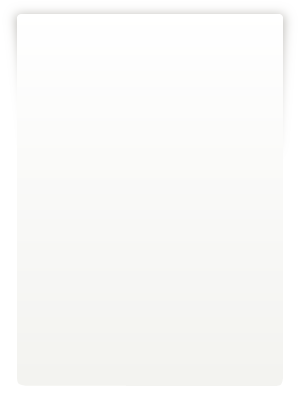
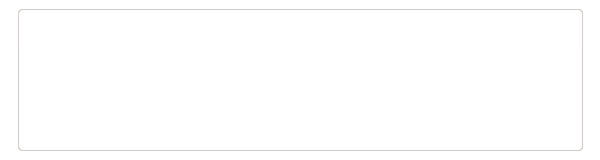
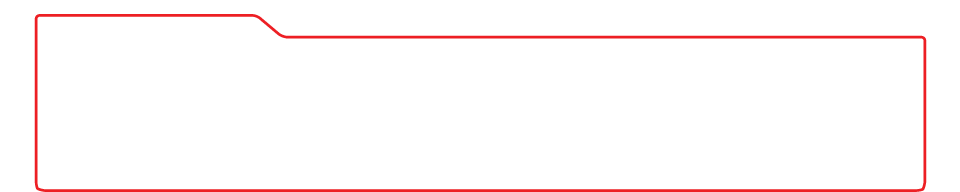
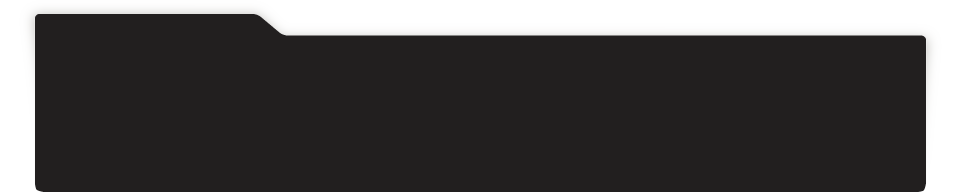
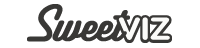
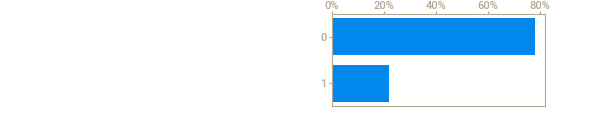
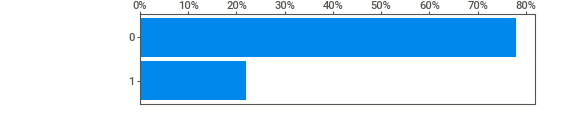
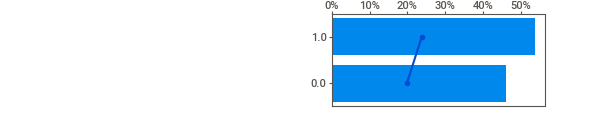
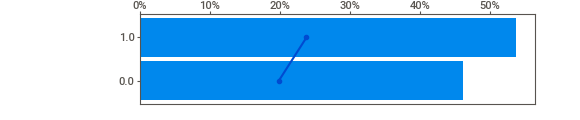
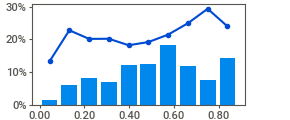
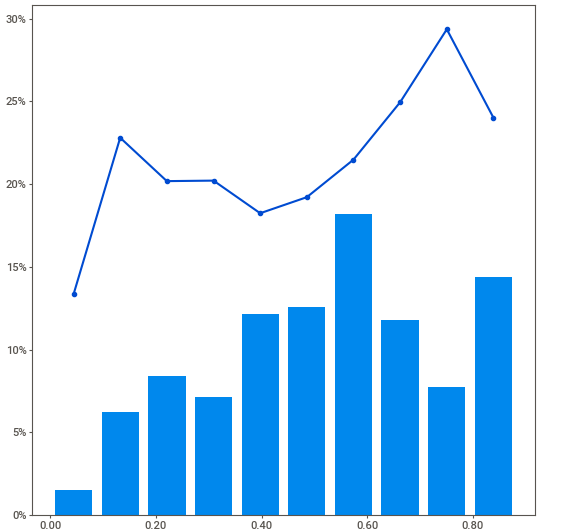
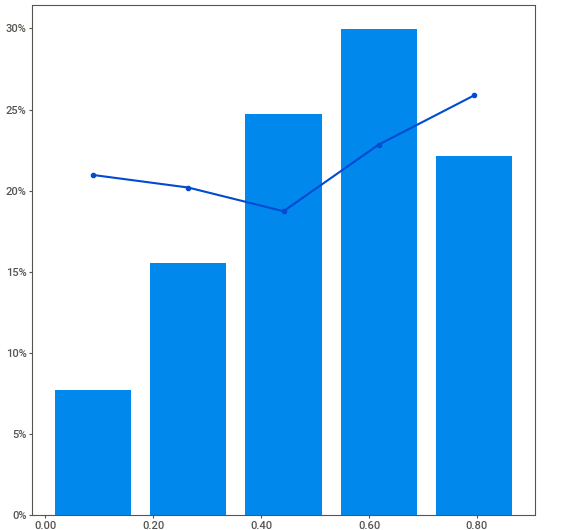
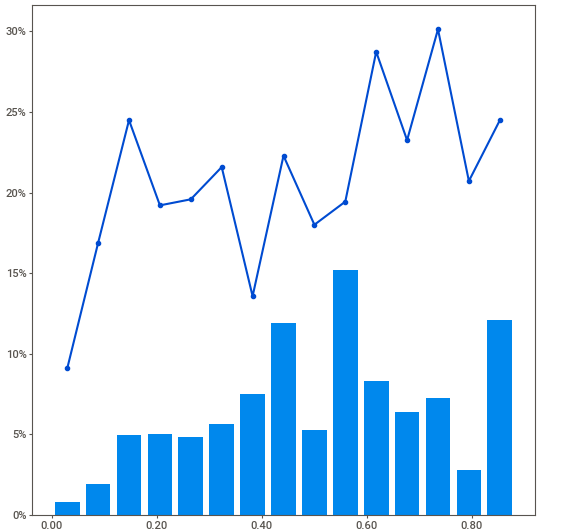
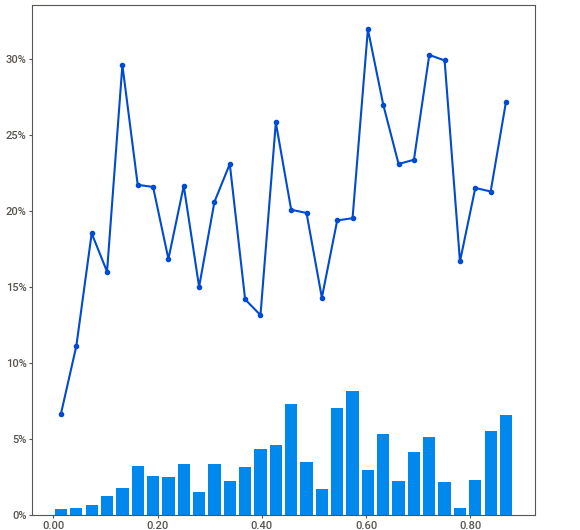
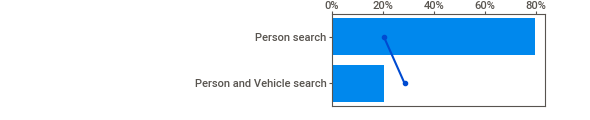
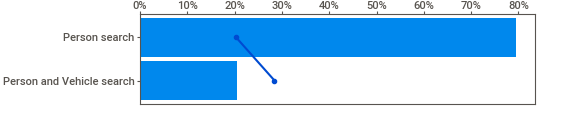
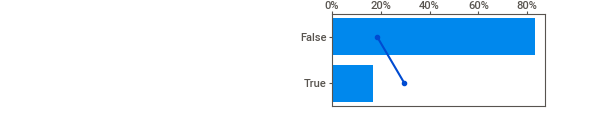
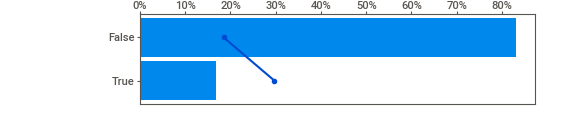
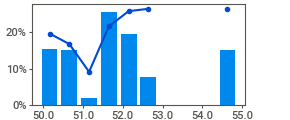
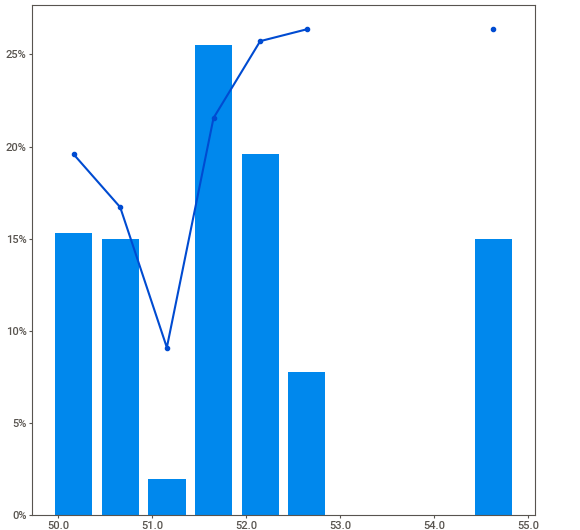
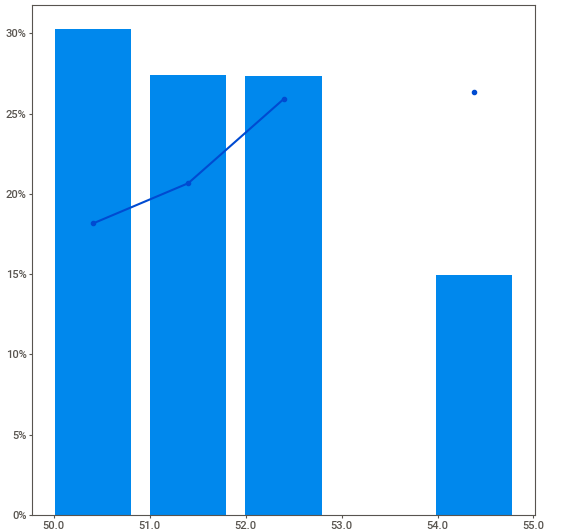
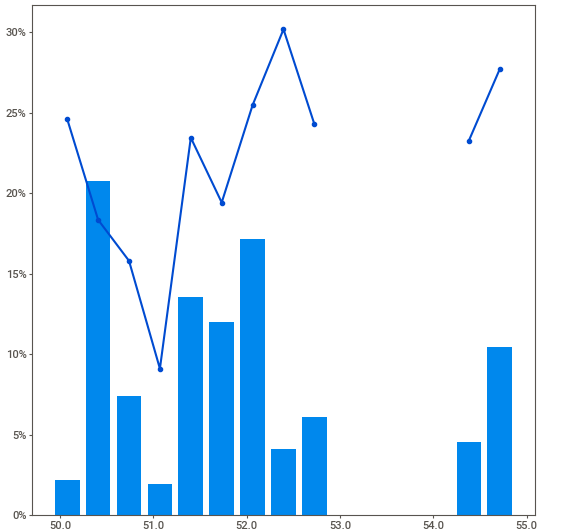
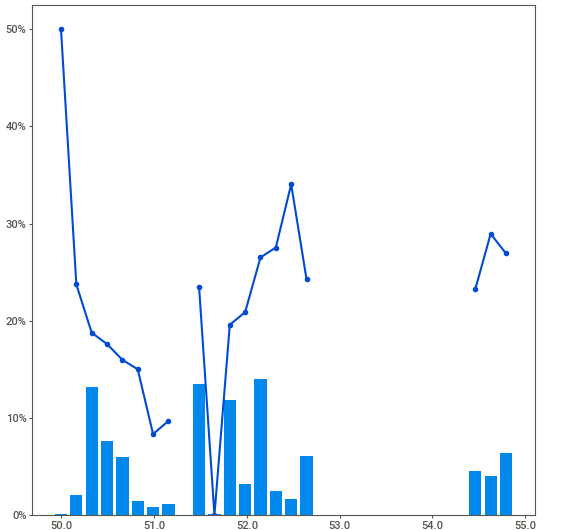
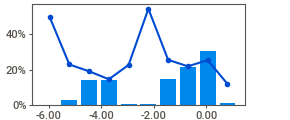
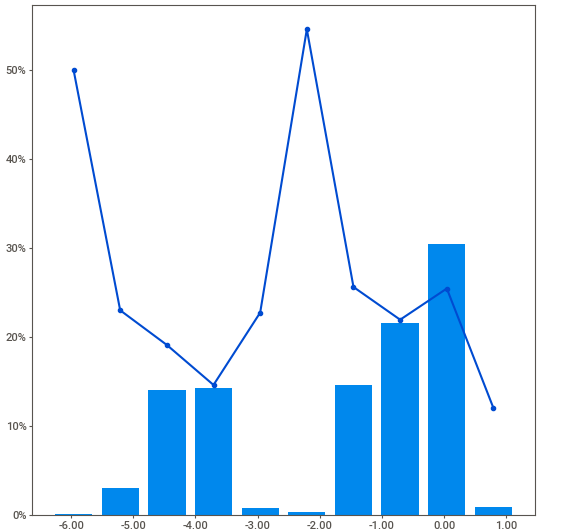
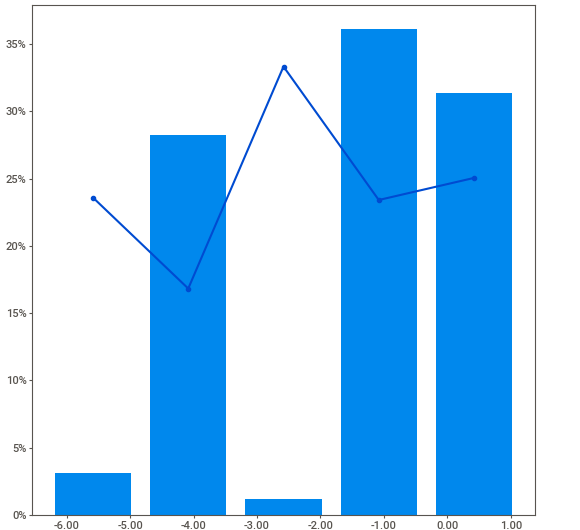
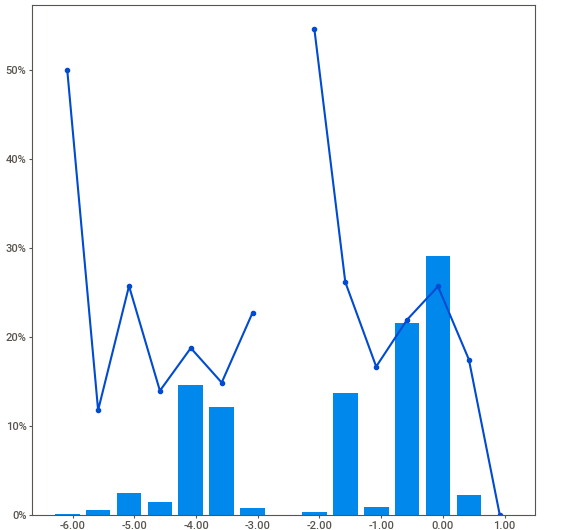
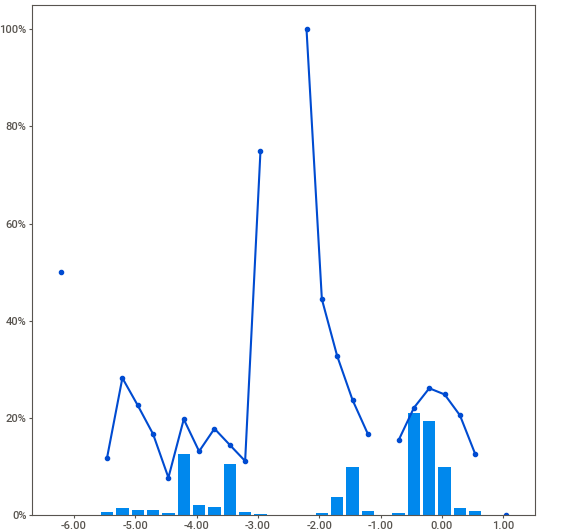
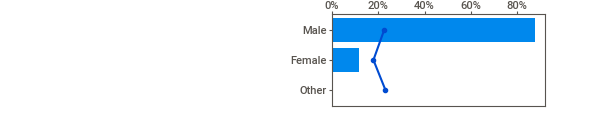
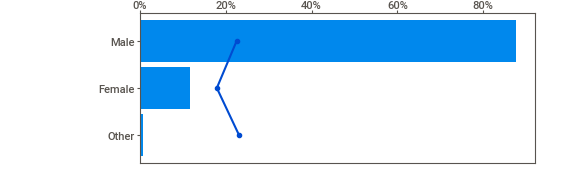
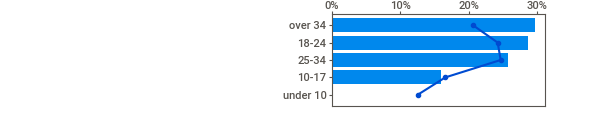
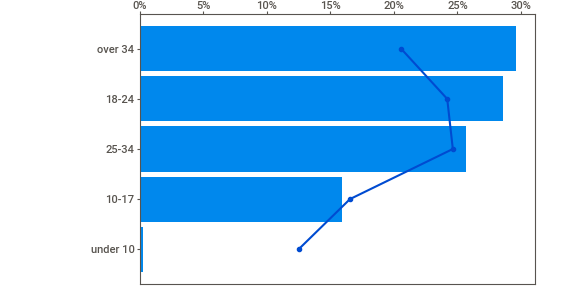
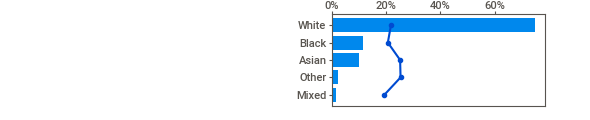
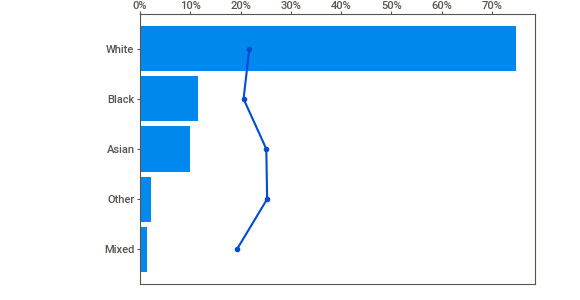
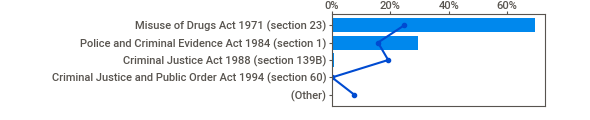
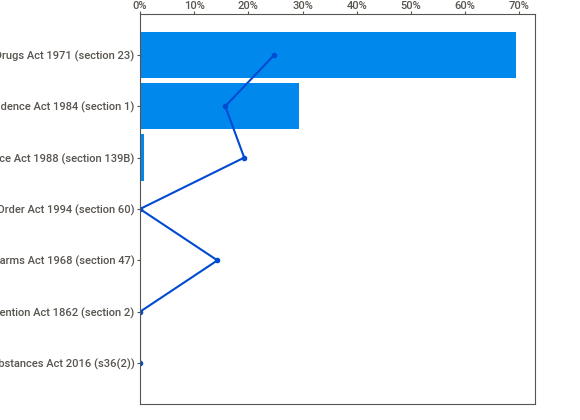
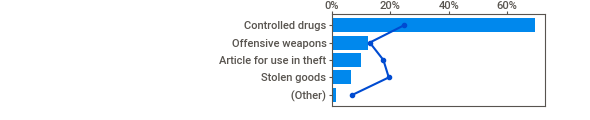
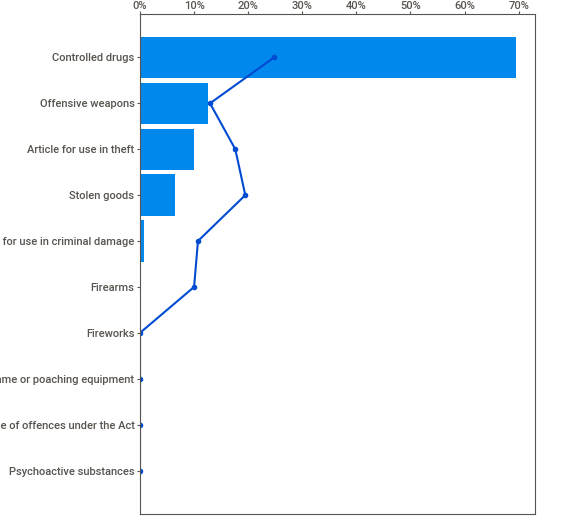
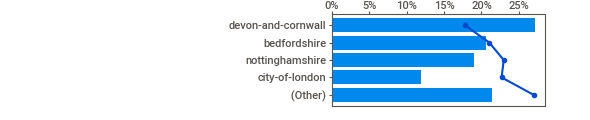
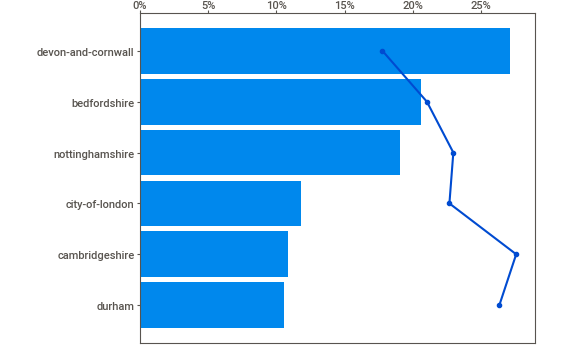
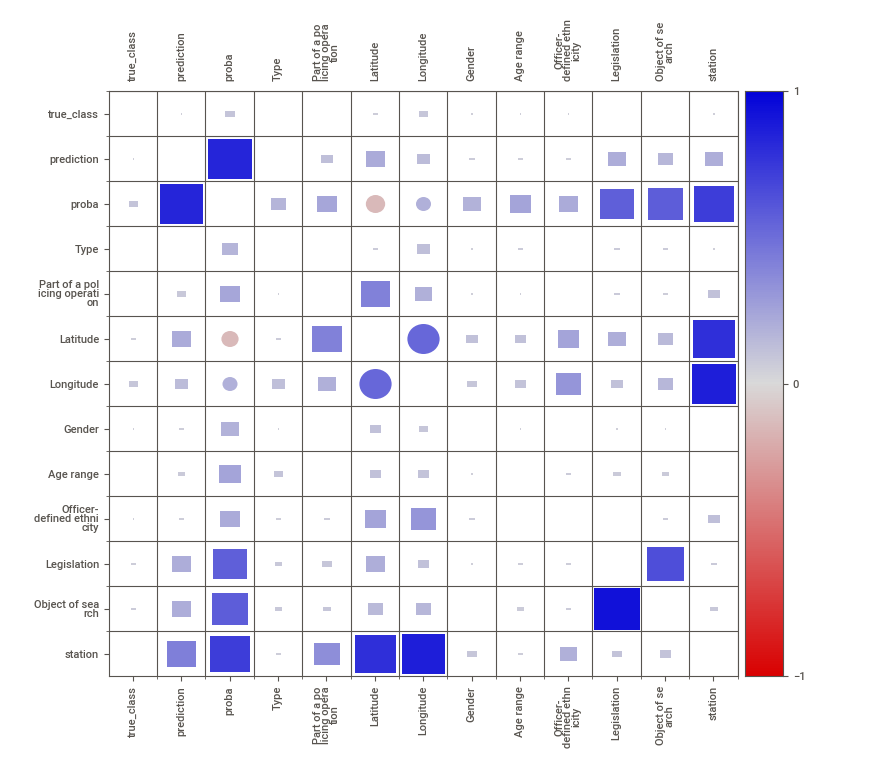
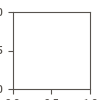

In [22]:
sweetviz.DataframeReport(
        data, 
        target_feature_name='true_class'
    ).show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


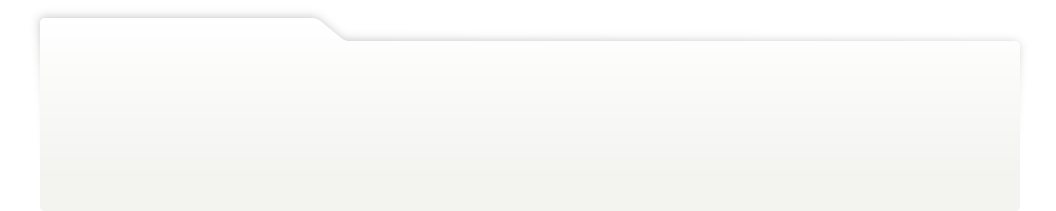
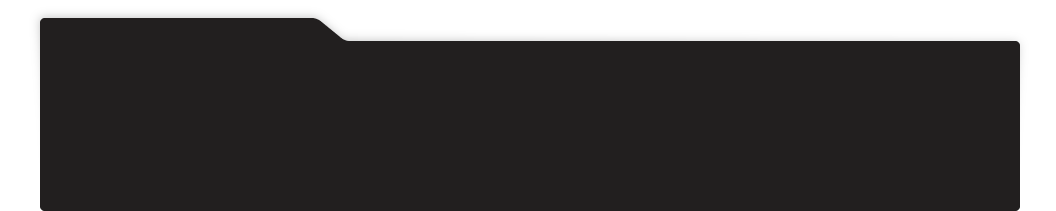
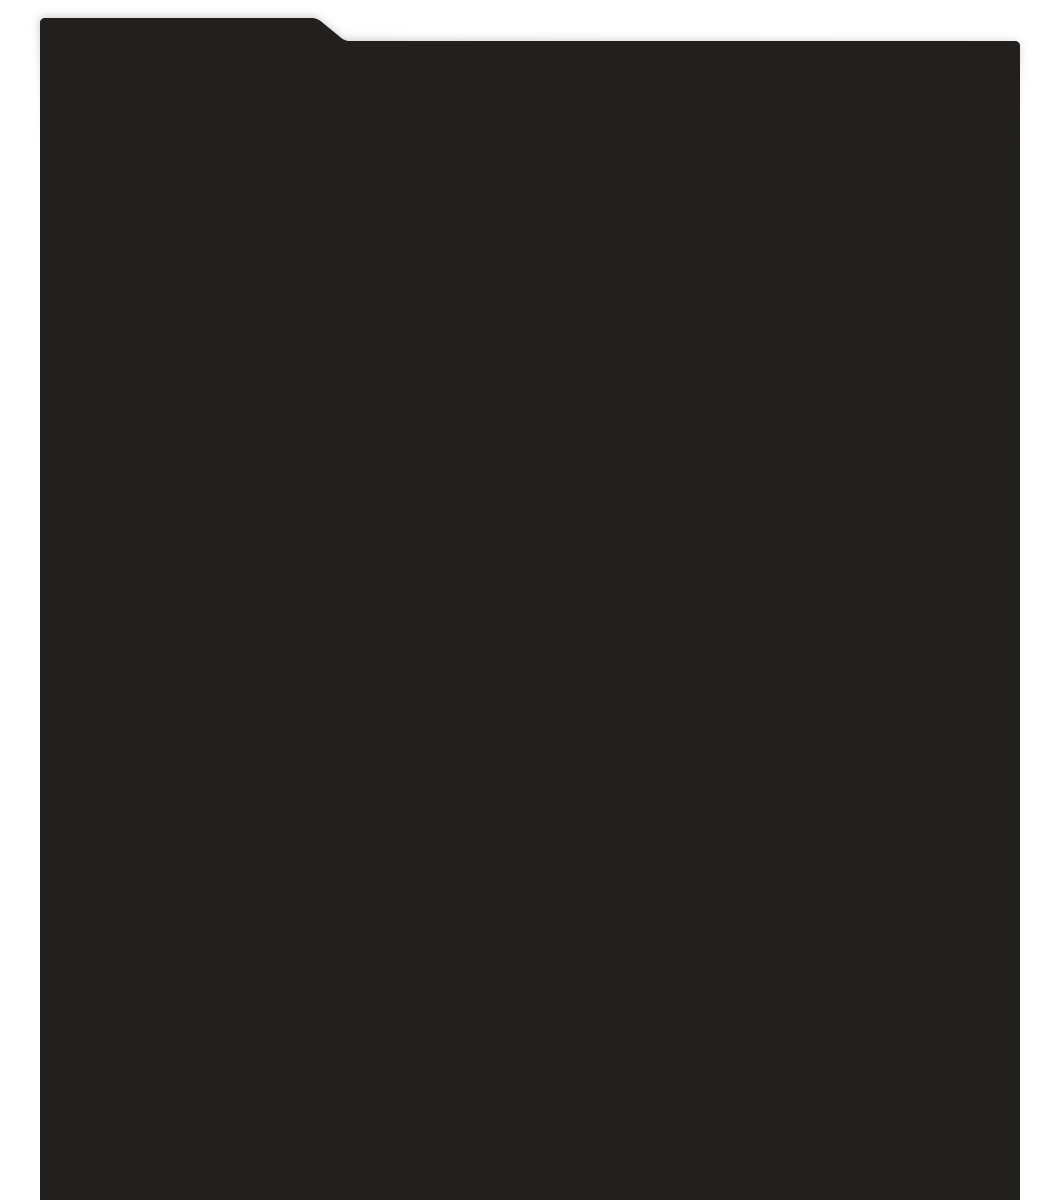
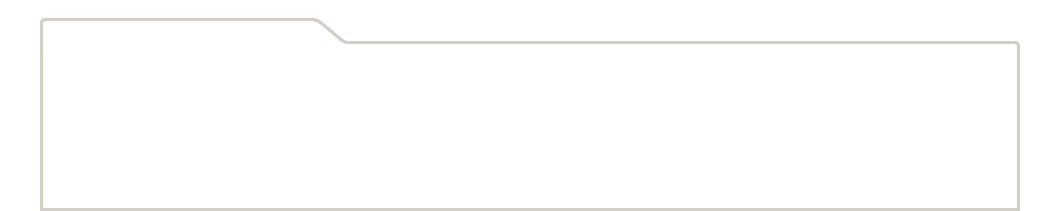
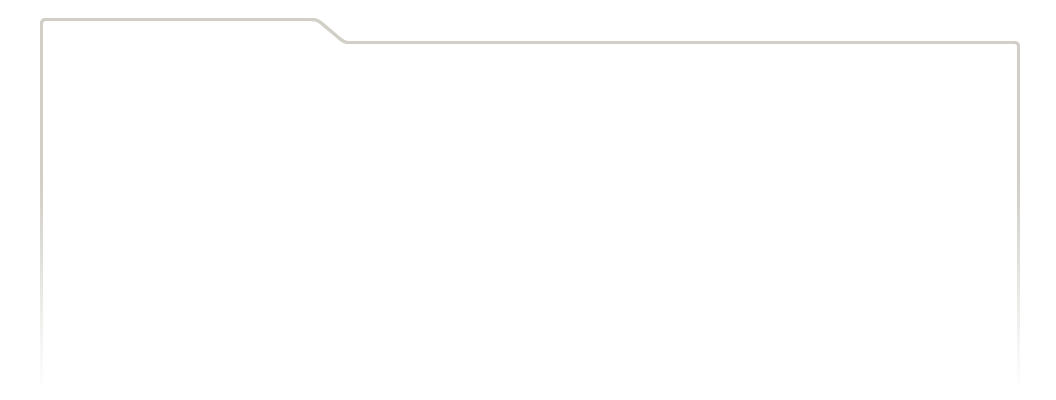
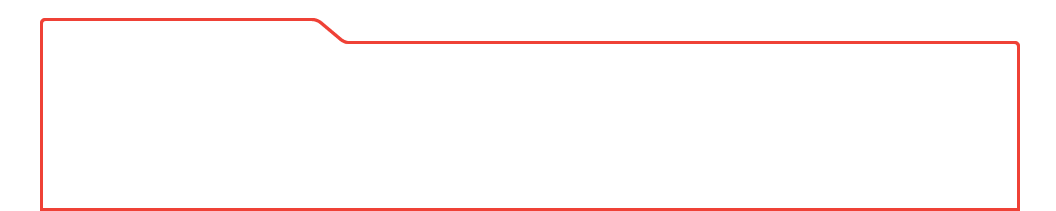
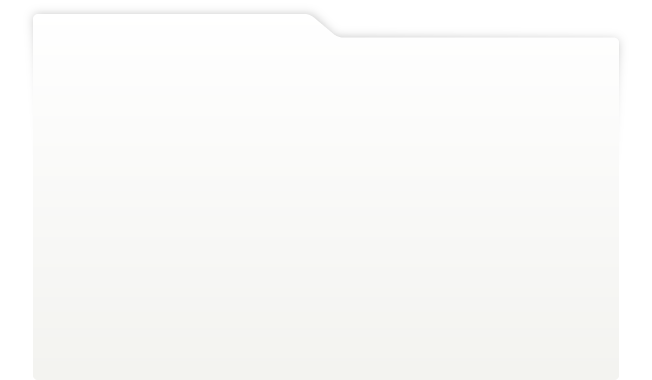
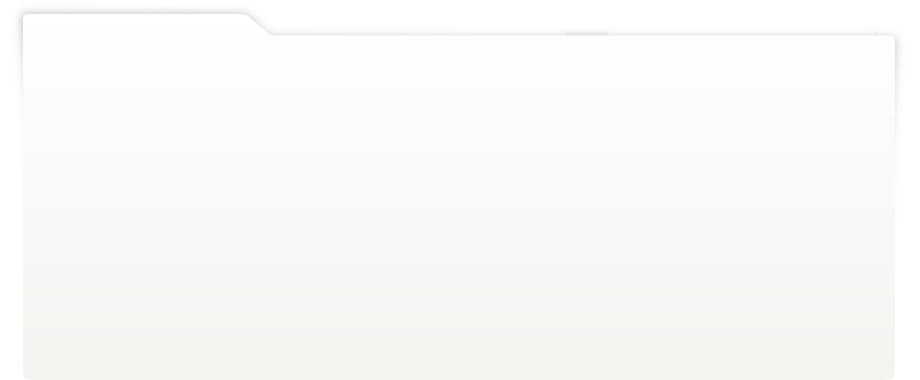
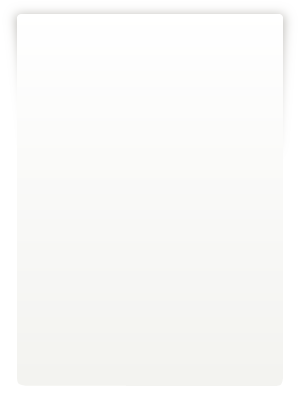
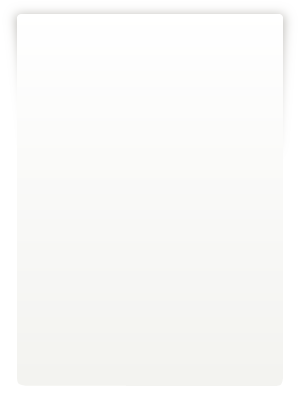
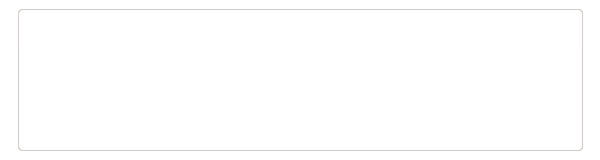
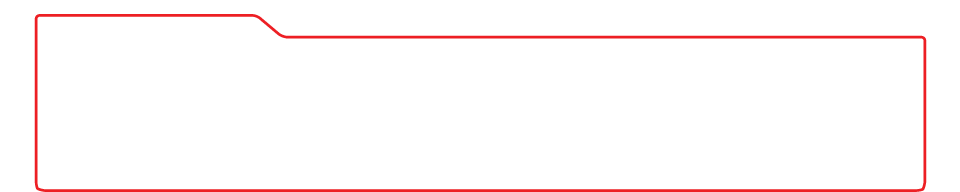
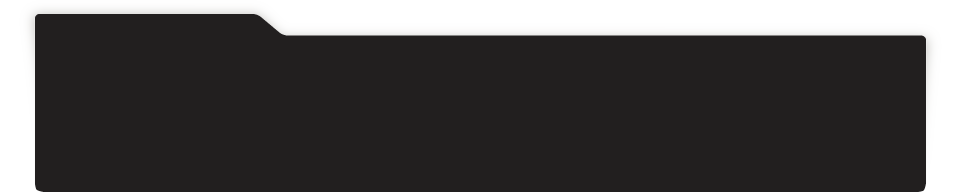
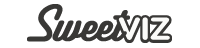
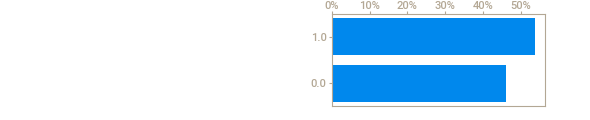
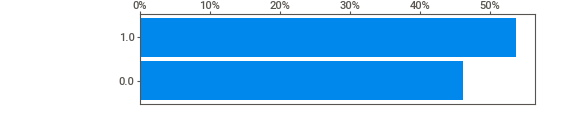
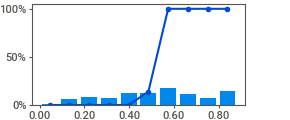
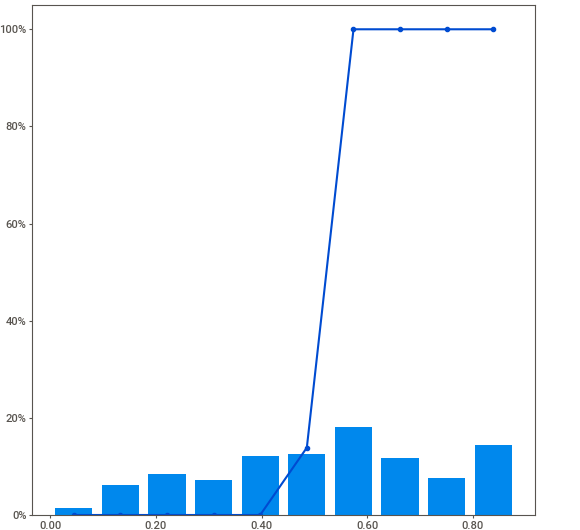
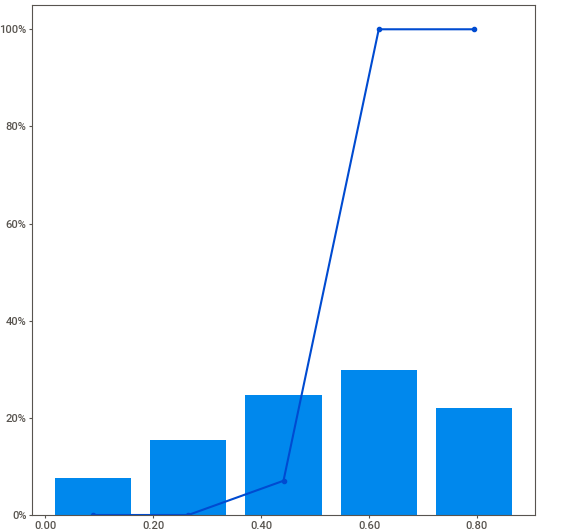
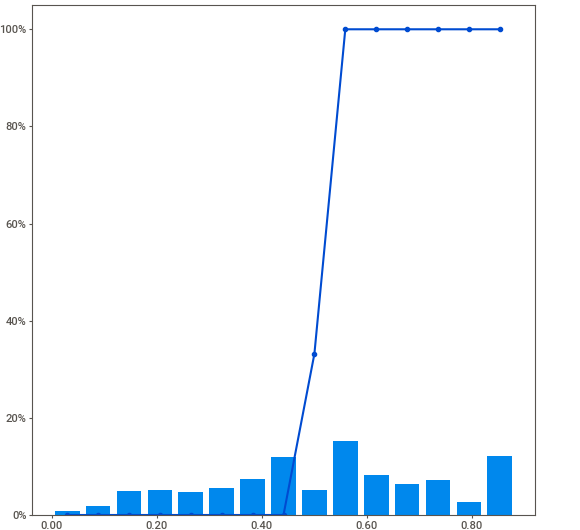
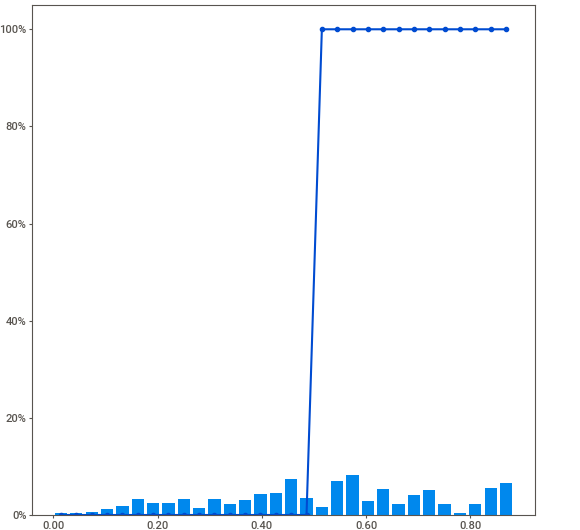
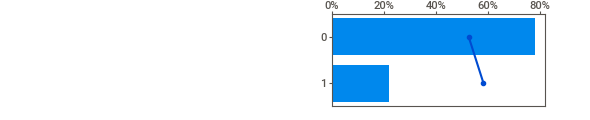
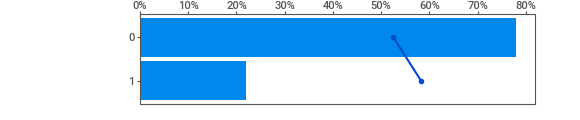
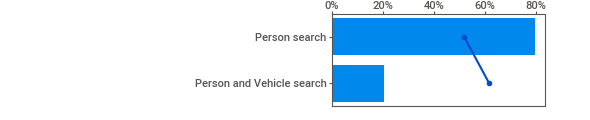
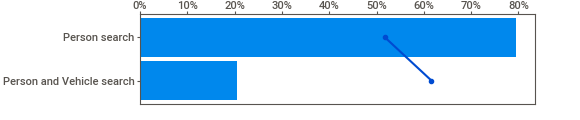
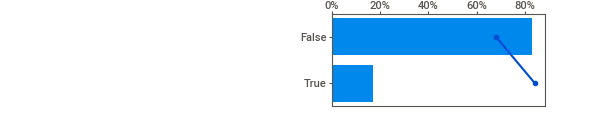
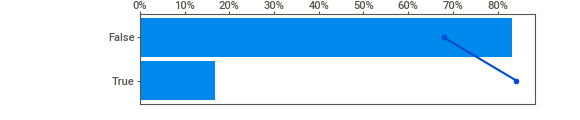
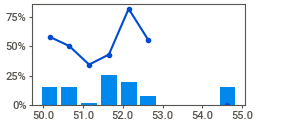
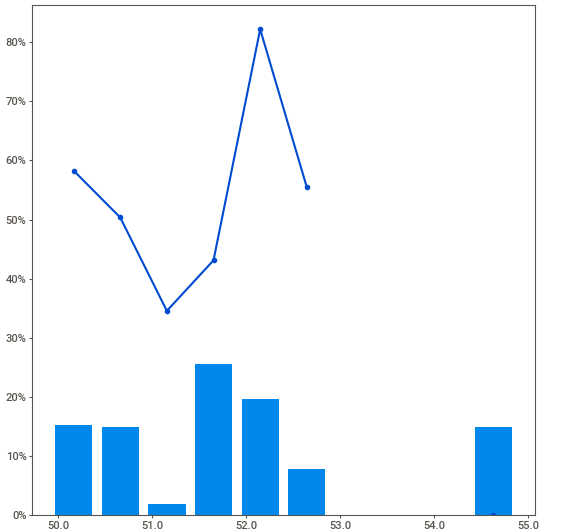
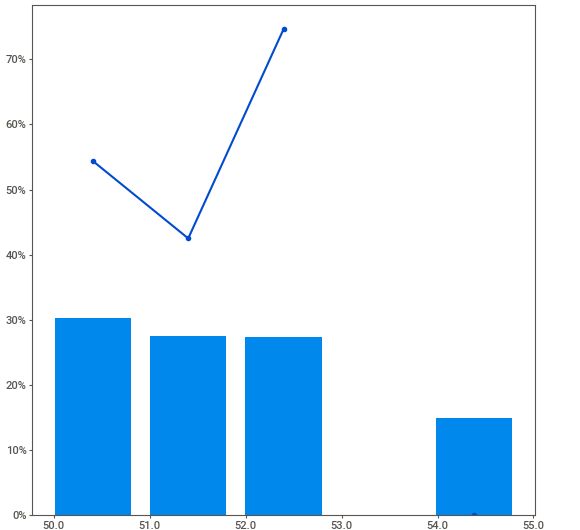
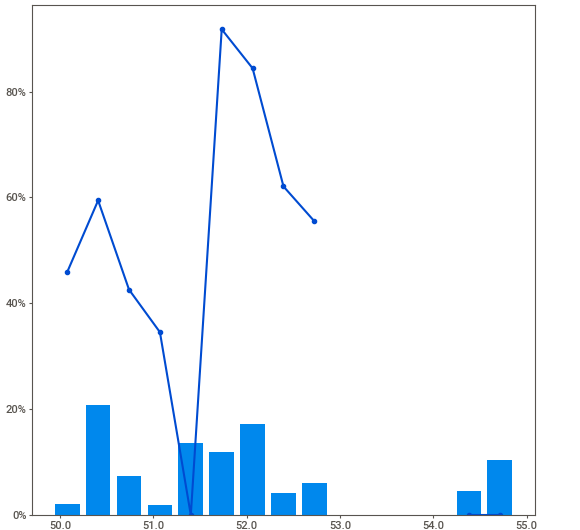
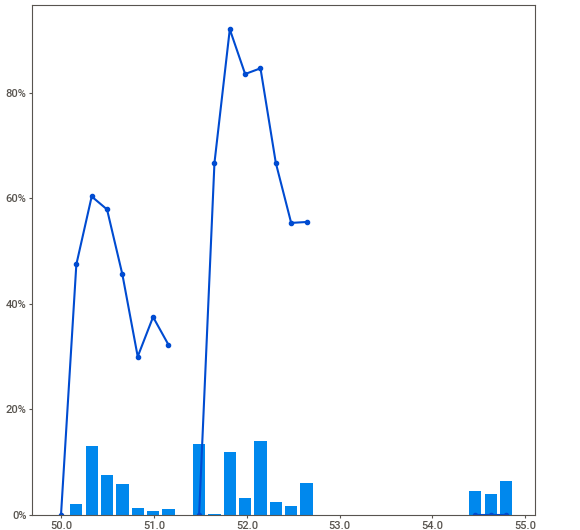
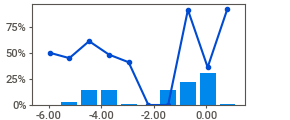
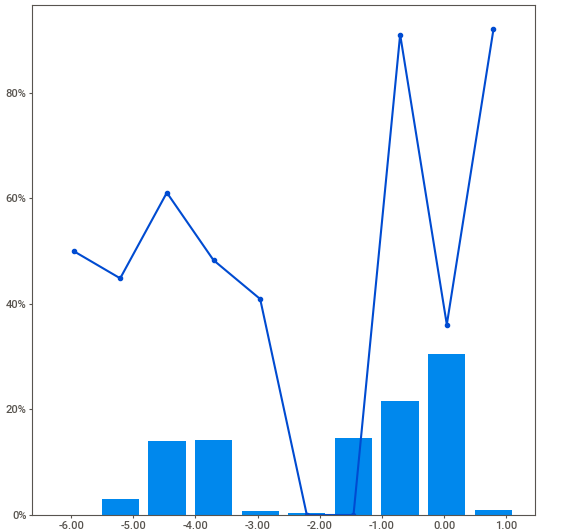
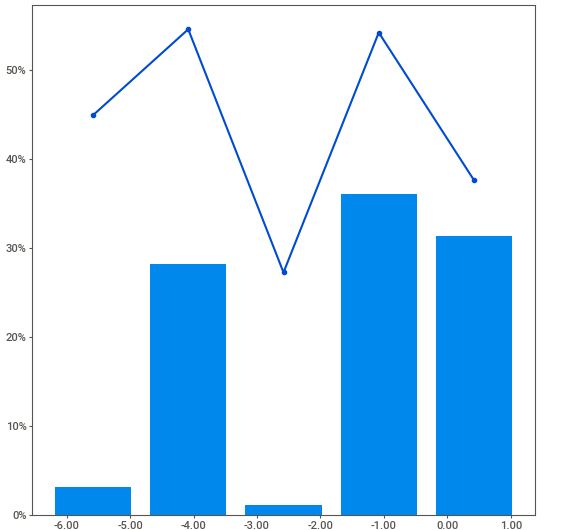
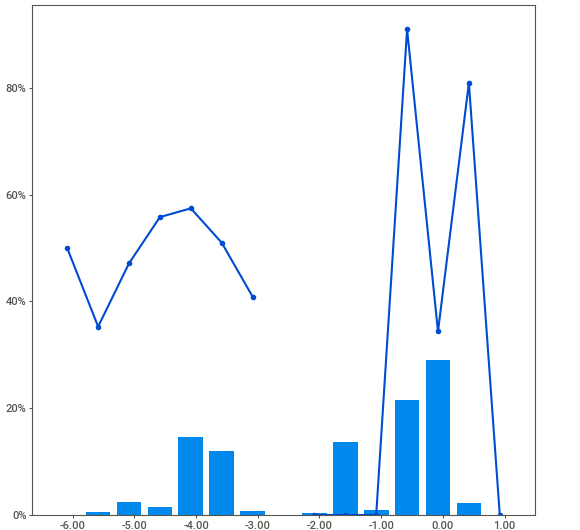
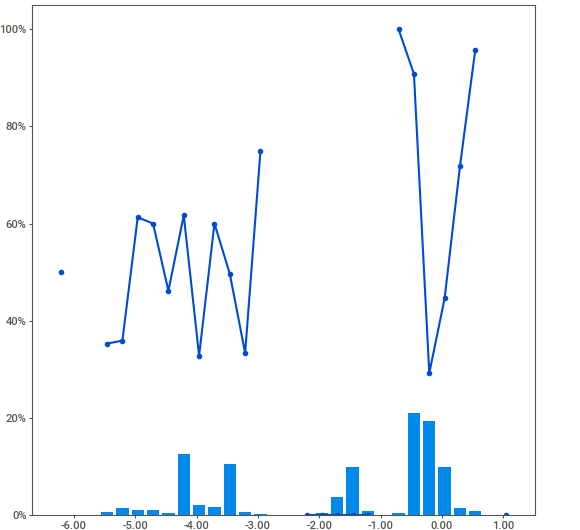
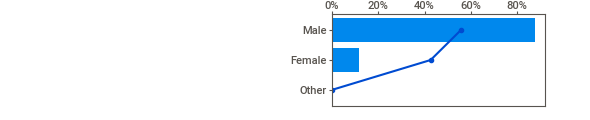
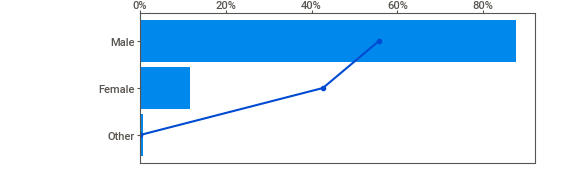
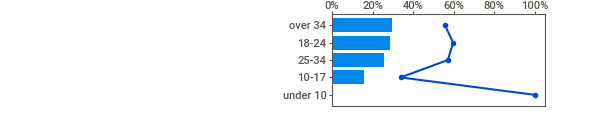
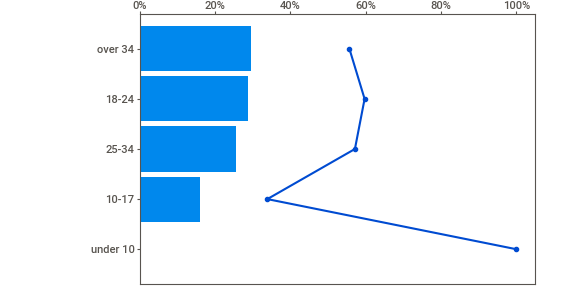
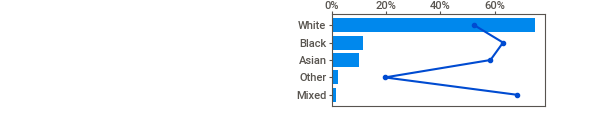
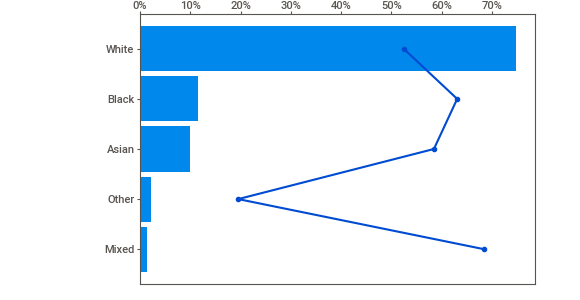
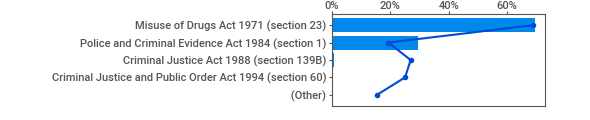
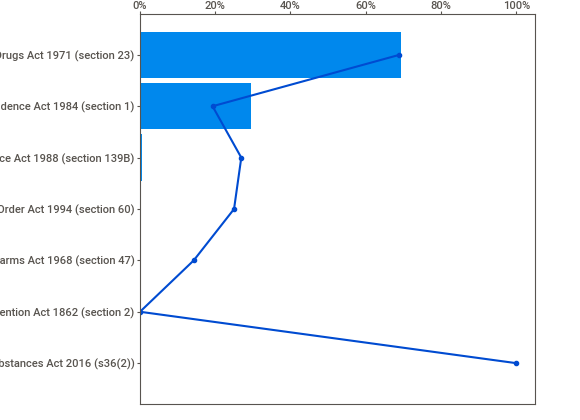
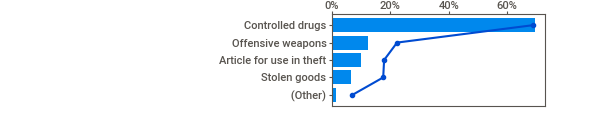
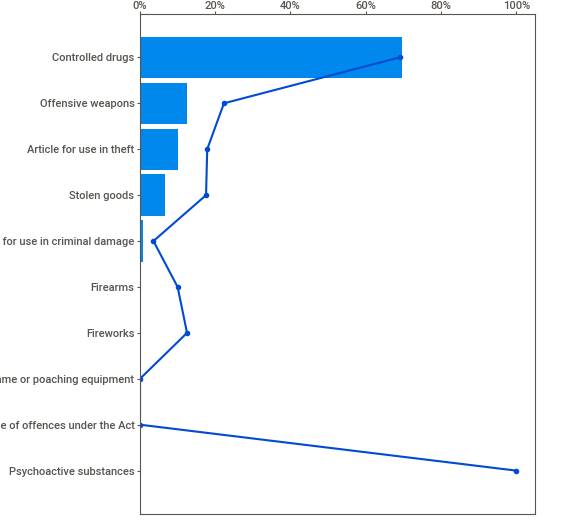
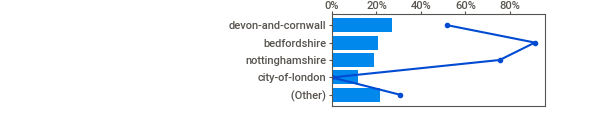
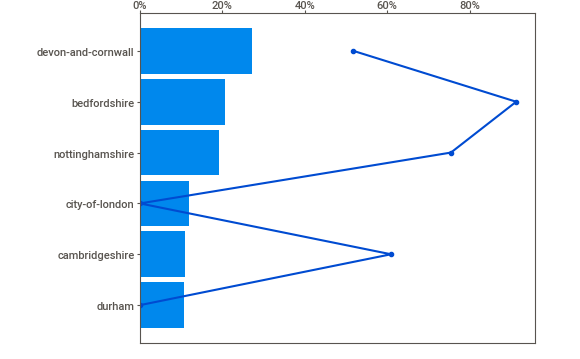
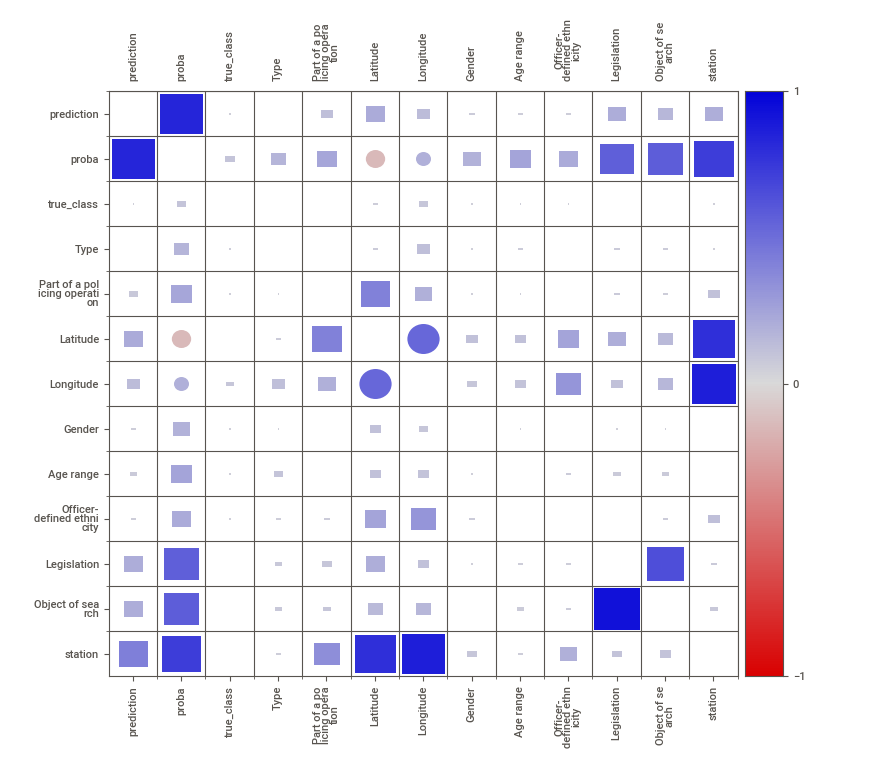
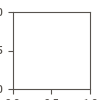

In [41]:
sweetviz.DataframeReport(
        data, 
        target_feature_name='prediction'
    ).show_notebook()

In [23]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    """
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    return is_satisfied, precision

In [24]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Gender', max_diff=0.05):
    """
    Verifies that no station has discrimination in sensitive_column
    
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments

In [25]:
def verify_across_stations(X_test, y_true, y_pred, max_diff=0.1, min_success_rate=0.1):
    """
    Verifies that no station has discrimination in sensitive_column
    
    
    """
    
    departments = X_test['station'].unique()

    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    precisions = []
    for department in departments:
        mask = (X_test['station'] == department)
        if mask.sum():
            station_precision = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
            precisions.append(station_precision)

        if station_precision < min_success_rate:
            problematic_departments.append((department, station_precision))
        else:
            good_deparments.append((department, station_precision))

    diff = np.max(precisions) - np.min(precisions)
    if diff > max_diff:
            is_satisfied = False

    return is_satisfied, diff, problematic_departments, good_deparments

In [26]:
data.columns

Index(['prediction', 'proba', 'true_class', 'observation_id', 'Type', 'Date',
       'Part of a policing operation', 'Latitude', 'Longitude', 'Gender',
       'Age range', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station'],
      dtype='object')

In [27]:
verify_success_rate_above(data.true_class, data.prediction)

(True, 0.23809523809523808)

In [28]:
verify_no_discrimination(data, data.true_class, data.prediction, sensitive_column='Gender')

(False,
 [('nottinghamshire',
   0.06377068785926465,
   {'Male': 0.2627599243856333, 'Female': 0.32653061224489793}),
  ('bedfordshire',
   0.06547445018354286,
   {'Male': 0.21601208459214502, 'Female': 0.15053763440860216}),
  ('cambridgeshire',
   0.10184102863822322,
   {'Male': 0.3432203389830508, 'Female': 0.2413793103448276})],
 [('city-of-london', 0.0, {'Male': 0.0, 'Female': 0.0}),
  ('durham', 0.0, {'Male': 0.0, 'Female': 0.0, 'Other': 0.0}),
  ('devon-and-cornwall',
   0.03281008749356665,
   {'Male': 0.20522388059701493, 'Female': 0.1724137931034483})])

In [29]:
verify_no_discrimination(data, data.true_class, data.prediction, sensitive_column='Officer-defined ethnicity')

(False,
 [('devon-and-cornwall',
   0.4375,
   {'Asian': 0.07142857142857142,
    'White': 0.20037453183520598,
    'Black': 0.4375,
    'Other': 0.0}),
  ('bedfordshire',
   0.19144144144144143,
   {'Asian': 0.25,
    'White': 0.21521739130434783,
    'Black': 0.14189189189189189,
    'Other': 0.3333333333333333}),
  ('cambridgeshire',
   0.35678391959798994,
   {'Asian': 0.25925925925925924,
    'White': 0.35678391959798994,
    'Black': 0.2702702702702703,
    'Other': 0.0})],
 [('city-of-london',
   0.0,
   {'Asian': 0.0, 'White': 0.0, 'Black': 0.0, 'Other': 0.0}),
  ('durham', 0.0, {'Asian': 0.0, 'White': 0.0, 'Black': 0.0, 'Other': 0.0}),
  ('nottinghamshire',
   0.044665012406947924,
   {'Asian': 0.3,
    'White': 0.2571428571428571,
    'Black': 0.3010752688172043,
    'Other': 0.2727272727272727,
    'Mixed': 0.2564102564102564})])

In [30]:
across_stations_is_satisfied, across_stations_diff, across_stations_problematic_departments, across_stations_good_deparments = verify_across_stations(data, data.true_class, data.prediction)

In [31]:
across_stations_is_satisfied

False

In [32]:
across_stations_diff

0.3320754716981132

In [33]:
across_stations_problematic_departments

[('city-of-london', 0.0), ('durham', 0.0)]

In [34]:
across_stations_good_deparments

[('devon-and-cornwall', 0.20353982300884957),
 ('nottinghamshire', 0.2681660899653979),
 ('bedfordshire', 0.20794701986754968),
 ('cambridgeshire', 0.3320754716981132)]

In [ ]:
data

In [36]:
recall_score(data.true_class, data.prediction)


0.582579185520362

In [39]:
precision, recall, thresholds = precision_recall_curve(data.true_class, data.proba)


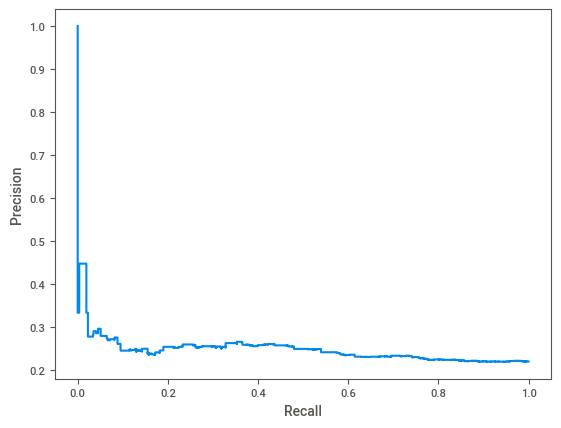

In [40]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot() 

In [48]:
thresholds.shape

(663,)

In [47]:
precision.shape

(664,)

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

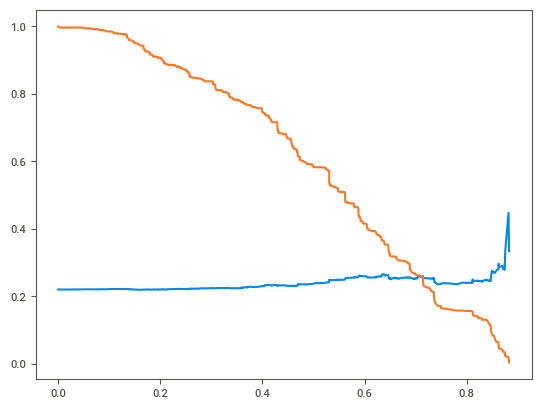

In [55]:
sns.lineplot(thresholds, precision[:-1])
sns.lineplot(thresholds, recall[:-1])

/home/jrr/.virtualenvs/capstone/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

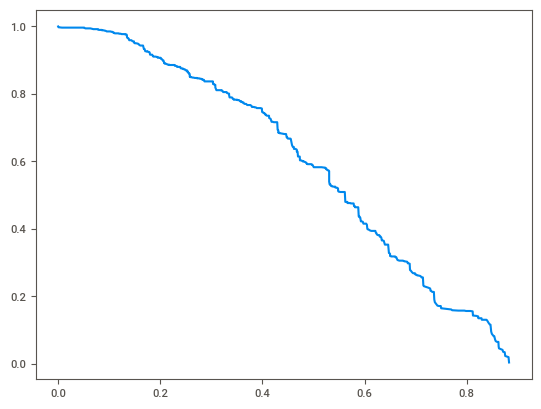

In [51]:
sns.lineplot(thresholds, recall[:-1])